In [3]:
!pip install pymoo

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# CPPN

Uma CPPN (Compositional Pattern Producing Networks) é uma rede neural que gera padrões (imagens, formas, etc.) a partir de coordenadas como entrada.

A entrada pode ser (x, y) (ou (x, y, z, t)), e a saída são valores que representam cor, intensidade, altura, etc.

Exemplo de CPPN que gera uma imagem a partir das coordenadas (x, y):

Funções de ativação definem como o neurônio responde ao valor que recebe como entrada. Sine tende a introduzir componentes oscilatórios (repetição), gaussian tende a criar centros/“bolhas”, e sigmoid comprime para (0,1)

In [ ]:
# Funções de ativação típicas de CPPNs

def sigmoid(x): return 1 / (1 + np.exp(-x))
def gaussian(x): return np.exp(-x**2)
def sine(x): return np.sin(x)
def linear(x): return x

Uma camada genérica em uma rede neural é um bloco que realiza o cálculo fundamental do modelo: ela recebe valores de entrada, multiplica por uma matriz de pesos, soma um termo de viés e aplica uma função de ativação para gerar as saídas. Essa estrutura é chamada “genérica” porque pode representar qualquer camada totalmente conectada, bastando definir o número de entradas, o número de neurônios de saída e o tipo de ativação desejado. Em uma CPPN, essas camadas são combinadas para transformar coordenadas de entrada (como xxx e yyy) em padrões complexos, sendo cada camada responsável por aplicar uma transformação matemática diferente sobre os dados.

In [ ]:
# Camada genérica
class Layer:
    def __init__(self, in_size, out_size, activation):
        self.W = np.random.randn(out_size, in_size)
        self.b = np.random.randn(out_size, 1)
        self.activation = activation

    def forward(self, x):
        return self.activation(self.W @ x + self.b)

A sua CPPN é uma sequência de camadas densas onde cada camada aplica uma transformação linear seguida por uma função de ativação (seno, gaussiana, sigmoid). query(x,y) constrói um vetor coluna com (x,y), passa esse vetor por todas as camadas e retorna um único escalar que representa intensidade/valor no ponto (x,y).

In [ ]:
# CPPN básica
class CPPN:
    def __init__(self):
        self.layers = [
            Layer(2, 8, sine),       # 2 entradas (x, y) e 8 neurônios de saída; usa sine como função de ativação
            Layer(8, 8, gaussian),   # recebe os 8 valores da camada anterior e produz 8 novos valores; usa gaussian
            Layer(8, 1, sigmoid)     # camada de saída: mapeia os 8 valores para 1 valor de saída e passa por sigmoid para ficar no intervalo (0,1)
        ]

    def query(self, x, y):
        input_vec = np.array([[x], [y]])
        out = input_vec
        for layer in self.layers:
            out = layer.forward(out)
        return out.item()

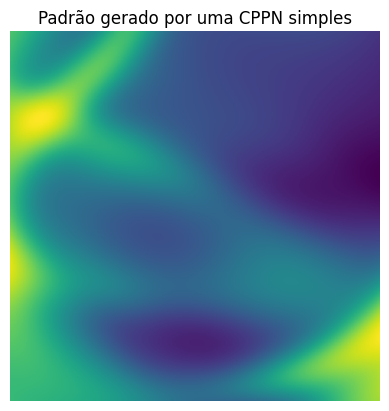

In [ ]:
# Geração da imagem
size = 256
xs = np.linspace(-1, 1, size)
ys = np.linspace(-1, 1, size)
cppn = CPPN()
img = np.zeros((size, size))

for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        img[j, i] = cppn.query(x, y)

plt.imshow(img, cmap='viridis')
plt.title("Padrão gerado por uma CPPN simples")
plt.axis('off')
plt.show()

# GA

Algoritmo Genético como uma simulação da seleção natural. Em uma "população" de soluções candidatas, as soluções que melhor resolvem o problema têm mais chances de "reproduzir" (trocar informações) e a cada "geração", a população de soluções vai melhorando, "evoluindo" em direção a uma solução ideal.

Problema Clássico "OneMax": Encontrar uma string binária de comprimento $N$ que contenha apenas o número 1.

In [ ]:
# --- 0. Parâmetros do Algoritmo Genético ---

TAMANHO_CROMOSSOMO = 400     # N: O número de bits em nossa string
TAMANHO_POPULACAO = 100   # O número de indivíduos em cada geração
TAXA_MUTACAO = 0.01       # 1% de chance de um bit sofrer mutação
TAXA_ELITISMO = 1         # Quantos "super" indivíduos passam direto para a próxima geração
NUM_GERACOES = 100        # Número máximo de gerações para rodar a simulação
TAMANHO_TORNEIO = 3       # Número de indivíduos que competem na seleção por torneio

In [ ]:
# --- 1. Inicialização ---

def criar_individuo():
    """Cria um indivíduo (cromossomo) aleatório."""
    # Um indivíduo é uma lista de 0s e 1s
    return [random.randint(0, 1) for _ in range(TAMANHO_CROMOSSOMO)]

def criar_populacao_inicial():
    """Cria a população inicial com 'TAMANHO_POPULACAO' indivíduos."""
    return [criar_individuo() for _ in range(TAMANHO_POPULACAO)]

In [ ]:
# --- 2. Função de Aptidão (Fitness) ---

def calcular_fitness(individuo):
    """
    Calcula o fitness de um indivíduo.
    Para o problema OneMax, o fitness é simplesmente a contagem de '1's.
    """
    return sum(individuo)

In [ ]:
# --- 3. Seleção ---

def selecionar_pai(populacao):
    """
    Seleciona um pai da população usando o método de "Seleção por Torneio".
    """
    # 1. Escolhe 'TAMANHO_TORNEIO' indivíduos aleatórios da população
    participantes = random.sample(populacao, TAMANHO_TORNEIO)

    # 2. O indivíduo com o maior fitness entre eles é o "vencedor"
    #    (Usamos 'key=calcular_fitness' para dizer ao max() como comparar)
    vencedor = max(participantes, key=calcular_fitness)

    return vencedor

In [ ]:
# --- 4. Cruzamento (Crossover) ---

def crossover(pai1, pai2):
    """
    Cria dois filhos a partir de dois pais usando "Crossover de Ponto Único".
    """
    # Escolhe um ponto de corte aleatório (sem ser nas pontas)
    ponto_corte = random.randint(1, TAMANHO_CROMOSSOMO - 1)

    # Cria os filhos combinando as partes dos pais
    filho1 = pai1[:ponto_corte] + pai2[ponto_corte:]
    filho2 = pai2[:ponto_corte] + pai1[ponto_corte:]

    return filho1, filho2

In [ ]:
def mutacao(individuo):
    """
    Aplica a mutação "Bit Flip" em um indivíduo.
    Cada bit tem 'TAXA_MUTACAO' de chance de ser invertido.
    """
    for i in range(TAMANHO_CROMOSSOMO):
        if random.random() < TAXA_MUTACAO:
            # Inverte o bit ( 1 -> 0  ou  0 -> 1 )
            individuo[i] = 1 - individuo[i]
    return individuo

In [ ]:
# --- O Loop Evolutivo Principal ---

def rodar_ga():
    """Executa o Algoritmo Genético."""

    # 1. Crie a população inicial
    populacao = criar_populacao_inicial()

    # Variáveis para acompanhar o melhor de todos
    melhor_fitness_global = -1
    melhor_individuo_global = None

    print(f"Iniciando GA para OneMax (Alvo de Fitness: {TAMANHO_CROMOSSOMO})...")
    print(f"Pop: {TAMANHO_POPULACAO} | Gerações: {NUM_GERACOES} | Mutação: {TAXA_MUTACAO*100}% | Elitismo: {TAXA_ELITISMO}")
    print("-" * 30)

    # 2. Comece o loop por gerações
    for geracao in range(NUM_GERACOES):

        # a. Avaliação: Calcule o fitness de todos e encontre o melhor da geração
        # (Nesta implementação, calculamos o fitness sob demanda, mas vamos
        # encontrar o melhor da geração atual para o log e para o elitismo)

        # Ordena a população pelo fitness (do melhor para o pior)
        populacao_ordenada = sorted(populacao, key=calcular_fitness, reverse=True)

        melhor_individuo_geracao = populacao_ordenada[0]
        fitness_geracao = calcular_fitness(melhor_individuo_geracao)

        # Atualiza o melhor global já encontrado
        if fitness_geracao > melhor_fitness_global:
            melhor_fitness_global = fitness_geracao
            melhor_individuo_global = melhor_individuo_geracao

        # Log (Impressão) do progresso
        print(f"Geração {geracao+1:03d} | Melhor Fitness: {melhor_fitness_global:02d}/{TAMANHO_CROMOSSOMO}")

        # b. Critério de Parada: Se encontramos a solução perfeita
        if melhor_fitness_global == TAMANHO_CROMOSSOMO:
            print(f"\nSolução perfeita encontrada na Geração {geracao+1}!")
            break

        # c., d., e. Criar a nova geração
        nova_populacao = []

        # Aplicar Elitismo: Os 'TAXA_ELITISMO' melhores indivíduos
        # passam para a próxima geração sem alterações.
        for i in range(TAXA_ELITISMO):
            nova_populacao.append(populacao_ordenada[i])

        # Preencher o resto da nova população com filhos
        while len(nova_populacao) < TAMANHO_POPULACAO:
            # c. Seleção
            pai1 = selecionar_pai(populacao)
            pai2 = selecionar_pai(populacao)

            # d. Crossover
            filho1, filho2 = crossover(pai1, pai2)

            # e. Mutação
            filho1_mutado = mutacao(filho1)
            filho2_mutado = mutacao(filho2)

            # Adiciona os novos filhos à nova população
            nova_populacao.append(filho1_mutado)
            if len(nova_populacao) < TAMANHO_POPULACAO:
                nova_populacao.append(filho2_mutado)

        # Substituição: A nova geração se torna a população atual
        populacao = nova_populacao

    # 3. Fim da Simulação: Imprime o resultado final
    print("-" * 30)
    print("Evolução concluída.")
    print(f"Melhor Indivíduo Global: {melhor_individuo_global}")
    print(f"Melhor Fitness Global:   {melhor_fitness_global}")

# --- Ponto de entrada do script ---
if __name__ == "__main__":
    rodar_ga()

Iniciando GA para OneMax (Alvo de Fitness: 400)...
Pop: 100 | Gerações: 100 | Mutação: 1.0% | Elitismo: 1
------------------------------
Geração 001 | Melhor Fitness: 219/400
Geração 002 | Melhor Fitness: 225/400
Geração 003 | Melhor Fitness: 236/400
Geração 004 | Melhor Fitness: 239/400
Geração 005 | Melhor Fitness: 239/400
Geração 006 | Melhor Fitness: 244/400
Geração 007 | Melhor Fitness: 251/400
Geração 008 | Melhor Fitness: 254/400
Geração 009 | Melhor Fitness: 259/400
Geração 010 | Melhor Fitness: 264/400
Geração 011 | Melhor Fitness: 266/400
Geração 012 | Melhor Fitness: 268/400
Geração 013 | Melhor Fitness: 269/400
Geração 014 | Melhor Fitness: 270/400
Geração 015 | Melhor Fitness: 275/400
Geração 016 | Melhor Fitness: 276/400
Geração 017 | Melhor Fitness: 278/400
Geração 018 | Melhor Fitness: 280/400
Geração 019 | Melhor Fitness: 282/400
Geração 020 | Melhor Fitness: 289/400
Geração 021 | Melhor Fitness: 291/400
Geração 022 | Melhor Fitness: 292/400
Geração 023 | Melhor Fitnes

# GA Multiobjetivo

Estamos procurando por um conjunto de soluções que representam os melhores "trade-offs" (compromissos) possíveis.

Dominância de Pareto: Uma Solução A domina uma Solução B se:
- A é pelo menos tão boa quanto B em todos os objetivos;
- A é estritamente melhor que B em pelo menos um objetivo;

Se A não domina B e B não domina A, elas são não-dominadas (ou "indiferentes"). Ambas são soluções de compromisso válidas. Fronteira de Pareto (ou Pareto Front) é o conjunto de todas as soluções não-dominadas.

## NSGA-II (Non-dominated Sorting Genetic Algorithm II)

Non-Dominated Sorting (Classificação Não-Dominada): Em vez de um único "melhor", o NSGA-II classifica a população inteira em "camadas" ou "fronteiras" (ranks):

- Rank 1 (A Elite): Todos os indivíduos que não são dominados por ninguém na população. (Esta é a "Fronteira de Pareto" da população atual).

- Rank 2: Todos os indivíduos que só são dominados por indivíduos do Rank 1.

- Rank 3: Todos os indivíduos que só são dominados por indivíduos do Rank 1 ou 2.

E assim por diante. Um indivíduo com Rank 1 é melhor que um com Rank 2. Se dois indivíduos estão no mesmo Rank, O NSGA-II prefere soluções que mantêm a Fronteira de Pareto diversificada e espalhada, calculando uma "distância de aglomeração" (crowding distance).

Aplicação de teste: minimizar as funções $x^2$ e $(x - 2)^2$, a fronteira de Pareto deve ser todos os números [0, 2].

In [4]:
# --- 1. Definir o Problema (A NOVA "FUNÇÃO FITNESS") ---
#
# Esta é a única parte que você realmente precisa mudar para
# seus próprios problemas.
#
class MeuProblema(Problem):

    def __init__(self):
        # Configuração do problema:
        super().__init__(
            n_var=1,         # n_var: Número de variáveis de decisão (apenas 'x')
            n_obj=2,         # n_obj: Número de objetivos (f1, f2)
            n_constr=0,      # n_constr: Número de restrições (nenhuma)
            xl=-10.0,        # xl: Limite inferior da variável 'x'
            xu=10.0          # xu: Limite superior da variável 'x'
        )

    def _evaluate(self, X, out, *args, **kwargs):
        """
        Aqui é onde a "mágica" acontece.
        'X' não é um indivíduo, mas um array (numpy) com
        a população inteira (ou um lote dela).
        X tem o formato [n_amostras, n_var]
        """

        # Pega a coluna 0 de todas as amostras (nossos valores de 'x')
        x = X[:, 0]

        # --- Objetivo 1 (Minimizar) ---
        f1 = x**2

        # --- Objetivo 2 (Minimizar) ---
        f2 = (x - 2.0)**2

        # O resultado 'out["F"]' deve ser um array onde cada
        # linha é um indivíduo e cada coluna é um objetivo.
        out["F"] = np.column_stack([f1, f2])

# --- 2. Instanciar o Problema ---
problema = MeuProblema()

In [5]:
# --- 3. Definir o Algoritmo ---
# Usamos o NSGA-II. A biblioteca cuida de toda a complexidade
# (Dominância, Crowding Distance, etc.) para nós.
algoritmo = NSGA2(
    pop_size=100,
    eliminate_duplicates=True
)

In [6]:
# --- 4. Executar a Otimização ---
# 'minimize' executa o loop de gerações.
# ('n_gen', 100) é o critério de parada.
res = minimize(
    problema,
    algoritmo,
    ('n_gen', 100),
    seed=1,
    verbose=True  # Mostra o progresso das gerações no console
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     11 |             - |             -
     2 |      200 |     24 |  0.0117280659 |         ideal
     3 |      300 |     51 |  0.0157103382 |             f
     4 |      400 |     93 |  0.0466569463 |         nadir
     5 |      500 |    100 |  0.0873169729 |         nadir
     6 |      600 |    100 |  0.0035794671 |         nadir
     7 |      700 |    100 |  0.0017312088 |             f
     8 |      800 |    100 |  0.0246368022 |         nadir
     9 |      900 |    100 |  0.0017251147 |             f
    10 |     1000 |    100 |  0.0032021603 |             f
    11 |     1100 |    100 |  0.0017541863 |             f
    12 |     1200 |    100 |  0.0034836552 |             f
    13 |     1300 |    100 |  0.0014753932 |             f
    14 |     1400 |    100 |  0.0025807559 |             f
    15 |     1500 |    100 |  0.0085760190 |         nadir
    16 |     1600 |    100 |  0.0017328223 |            


Otimização Multi-Objetivo Concluída.
Encontrados 100 indivíduos na fronteira de Pareto.


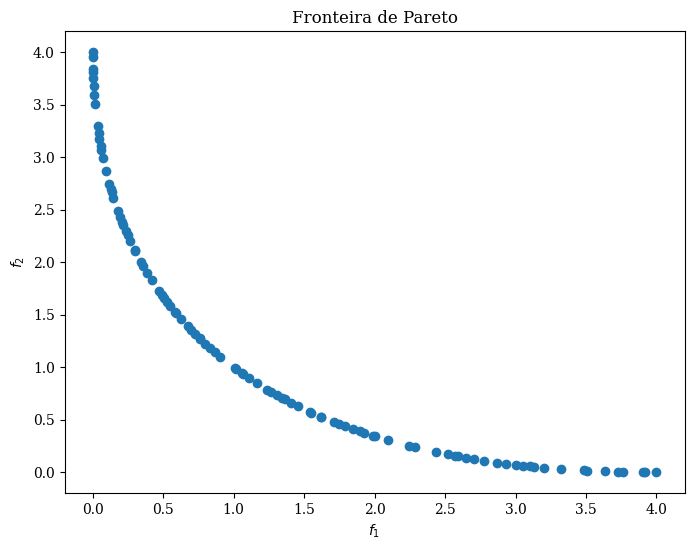

In [7]:
# --- 5. Analisar os Resultados ---
print("\n" + "="*30)
print("Otimização Multi-Objetivo Concluída.")

# 'res.X' contém as *variáveis de decisão* (os valores de 'x')
# que formam a fronteira.
print(f"Encontrados {len(res.X)} indivíduos na fronteira de Pareto.")

# 'res.F' contém os *valores dos objetivos* (os pares [f1, f2])
# de cada indivíduo na fronteira. Este é o dado que plotamos.
# print("\nValores dos Objetivos (Fronteira):")
# print(res.F)

# Plotar a Fronteira de Pareto
# (Irá abrir uma janela de gráfico)
plot = Scatter(
    title="Fronteira de Pareto",
    xlabel="Objetivo 1 ($f_1 = x^2$)",
    ylabel="Objetivo 2 ($f_2 = (x-2)^2$)"
)
plot.add(res.F) # 'res.F' são os valores [f1, f2]
plot.show()